## Importing the Needed Libraries

In [42]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import os
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"

from tqdm.auto import tqdm
import time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", message="`BaseEstimator._validate_data` is deprecated")
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

## Reading the Dataset and Split it into Train & Test

In [43]:
df_train = pd.read_csv("../../data/Faker_Data/train.csv")
df_test = pd.read_csv("../../data/Faker_Data/test.csv")

In [44]:
df_train = df_train[~((df_train["years_at_company"] == 0) & (df_train.age > 45))].copy()
df_train.drop(columns=['employee_id'], inplace=True)
df_test = df_test[~((df_test["years_at_company"] == 0) & (df_test.age > 45))].copy()
df_test.drop(columns=['employee_id'], inplace=True)
X_train = df_train.drop('attrition', axis=1)
y_train = df_train['attrition']
X_test = df_test.drop('attrition', axis=1)
y_test = df_test['attrition']


y_train = y_train.map({'Left': 0, 'Stayed': 1})
y_test = y_test.map({'Left': 0, 'Stayed': 1})
print("Labels : (0: Left, 1: Stayed)")
print(f" y_train_classes = {y_train.unique()}\n y_test_classes = {y_test.unique()}")

Labels : (0: Left, 1: Stayed)
 y_train_classes = [0 1]
 y_test_classes = [1 0]


## Prepare the Columns for Transformation in a Pipeline

In [45]:
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
nominal_cols = ["job_role", "marital_status"]
binary_cols = [
    "gender",
    "overtime",
    "remote_work",
    "leadership_opportunities",
    "innovation_opportunities",
]
ordinal_cols = [
    "work_life_balance",
    "job_satisfaction",
    "performance_rating",
    "education_level",
    "job_level",
    "company_size",
    "company_reputation",
    "employee_recognition",
    "age_groups",
]
numeric_cols

['age',
 'years_at_company',
 'monthly_income',
 'number_of_promotions',
 'distance_from_home',
 'number_of_dependents',
 'age_before_working']

In [46]:
numerical_pipeline = Pipeline([('scaler', StandardScaler())])

one_hot_encode = OneHotEncoder()

binary_pipeline = Pipeline([("binary", OrdinalEncoder(categories=[
    ['Female', 'Male'],
    ['No', 'Yes'],
    ['No', 'Yes'],
    ['No', 'Yes'],
    ['No', 'Yes'],
]))])


ordinal_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder(categories=[
        ['Poor', 'Fair', 'Good', 'Excellent'], #work life balance
        ['Low', 'Medium','High', 'Very High',], # job satisfaction
        ['Low', 'Average', 'High','Excellent'], # Performance Rating
        ['High School', 'Associate Degree', 'Bachelor’s Degree', 'Master’s Degree', 'PhD'], #Educational Level
        ['Entry', 'Mid', 'Senior'], # Job Level
        ['Small', 'Medium', 'Large'], #Company Size
        ['Poor', 'Fair','Good', 'Excellent'], # Company Reputation
        ['Low', 'Medium','High', 'Very High'], #employee recognition
        ['18-25', '26-35', '36-45', '46-55', '55+'] # age groups
    ]))
])

In [47]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numeric_cols),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('bin', binary_pipeline, binary_cols),
    ('one', one_hot_encode, nominal_cols)
])

In [48]:
# rfe_estimator = RandomForestClassifier(
#     max_depth=20,
#     min_samples_leaf=4,
#     min_samples_split=20,
#     n_estimators=100,
#     random_state=42
# )
# rfe = RFE(estimator=rfe_estimator, step=1)

pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        (
            "feature_selection",
            SelectFromModel(
                XGBClassifier(
                    use_label_encoder=False,
                    eval_metric="logloss",
                    max_depth=5,
                    learning_rate=0.2,
                    n_estimators=100,
                    random_state=42,
                ),
                threshold="median",  # or "mean" or custom importance cutoff
            ),
        ),
        (
            "smote",
            SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=9, n_jobs=-1),
        ),
        (
            "classifier",
            XGBClassifier(
                use_label_encoder=False,
                eval_metric="logloss",
                learning_rate=0.2,
                max_depth=5,
                n_estimators=100,
                random_state=42,
            ),
        ),
        # ("select", SelectKBest(score_func=f_classif, k=25)),
        # ("feature_selection", SelectKBest(score_func=chi2, k=25)),
        # ('select', SelectFromModel(LogisticRegression(max_iter=2000))),
        # ('feature_selection', rfe),
        # ("classifier", RandomForestClassifier(max_depth= 20, min_samples_leaf=4, min_samples_split=20, n_estimators=100, random_state=42)),
    ]
)

In [49]:
model = pipeline.fit(X_train, y_train)

/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [50]:
X_encoded = model.named_steps["preprocessor"].transform(X_train)

# get the column names from the ColumnTransformer
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

df_encoded = pd.DataFrame(X_encoded, columns=feature_names)
selected_mask = pipeline.named_steps['feature_selection'].get_support()
selected_columns = df_encoded.columns[selected_mask]
print("Selected Features:")
print(selected_columns, f"\n Number of the selected feature : {len(selected_columns)}")

Selected Features:
Index(['num__years_at_company', 'num__monthly_income',
       'num__number_of_promotions', 'ord__work_life_balance',
       'ord__job_satisfaction', 'ord__job_level', 'ord__company_size',
       'ord__company_reputation', 'ord__employee_recognition', 'bin__overtime',
       'bin__leadership_opportunities', 'one__job_role_Education',
       'one__job_role_Media', 'one__marital_status_Divorced',
       'one__marital_status_Single'],
      dtype='object') 
 Number of the selected feature : 15


In [51]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'years_at_company',
                                                   'monthly_income',
                                                   'number_of_promotions',
                                                   'distance_from_home',
                                                   'number_of_dependents',
                                                   'age_before_working']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['Poor',
                                                                                               'Fair',
                                                                                               'Good',
                                                                                               'Excellent'],
                                                                                              ['Lo...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [52]:
y_pred =model.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)

Accuracy: 0.89748322147651
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5969
           1       0.91      0.94      0.92     11911

    accuracy                           0.90     17880
   macro avg       0.89      0.88      0.88     17880
weighted avg       0.90      0.90      0.90     17880

Confusion Matrix:
 [[ 4863  1106]
 [  727 11184]]


## Starting with Modeling and Grid Search

In [53]:
models = {
    "RandomForest": (RandomForestClassifier(random_state=42, max_features='sqrt'), {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 15, 20],
        'classifier__min_samples_split': [10, 20],
        'classifier__min_samples_leaf': [4, 8]
    }),
    "KNN": (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }),
    "XGBoost": (XGBClassifier(eval_metric='logloss', random_state=42), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.05, 0.1, 0.2]
    }),
    "LogisticRegression": (
        LogisticRegression(max_iter=2000, solver='liblinear'),
        {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2']
        }
    ),
    "NaiveBayes": (
        GaussianNB(),
        {
            # GaussianNB has no major hyperparameters, so we keep it simple
            'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    ),
}

In [54]:
def grid_search_with_tqdm(
    model_name, model, params, X_train, y_train, X_test, y_test, preprocessor
):

    print(f"\n🔹 Training {model_name} with Grid Search + SMOTE...")
    time.sleep(0.3)

    # Build pipeline
    pipeline = ImbPipeline(
        [
            ("preprocessor", preprocessor),
            ("feature_selection", SelectKBest(score_func=f_classif, k=25)),
            (
                "smote",
                SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=9),
            ),
            ("classifier", model),
        ]
    )

    # Parameter combinations
    param_list = list(ParameterGrid(params))
    total_combinations = len(param_list)

    print(f"📊 Total parameter combinations: {total_combinations}")

    best_score = 0
    best_params = None
    best_model = None

    with tqdm(
        total=total_combinations, desc=f"Training {model_name}", unit="comb"
    ) as pbar:

        for param_set in param_list:
            pipeline.set_params(**param_set)

            # Fit model
            pipeline.fit(X_train, y_train)

            preds = pipeline.predict(X_test)
            f1 = f1_score(y_test, preds, average="weighted")

            # Track best model
            if f1 > best_score:
                best_score = f1
                best_params = param_set
                best_model = clone(pipeline)
                best_model.fit(X_train, y_train)   # make sure it's properly trained

            pbar.update(1)

    print(f"\n✅ Finished training {model_name}.")
    print(f"🔍 Best F1-score: {best_score:.3f}")
    print(f"✨ Best Parameters: {best_params}")

    # Final evaluation
    preds = best_model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")

    print(f"\n📊 Final Evaluation for {model_name}")
    print(f"Accuracy: {acc:.3f} | F1-score: {f1:.3f}\n")
    print(classification_report(y_test, preds))
    
    return best_model, best_params, best_score, acc

In [55]:
def make_roc_curve(model, X_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [56]:
def make_confusion_matrix(model, X_test, y_test, model_name="Model"):
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### **1. XGBoost Model**

In [57]:
xg_best_model, xg_best_params, xg_best_score, xg_acc = grid_search_with_tqdm(
    "XGBoost",
    models["XGBoost"][0],
    models["XGBoost"][1],
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor,
)


🔹 Training XGBoost with Grid Search + SMOTE...


📊 Total parameter combinations: 18


Training XGBoost:   0%|          | 0/18 [00:00<?, ?comb/s]


✅ Finished training XGBoost.
🔍 Best F1-score: 0.897
✨ Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

📊 Final Evaluation for XGBoost
Accuracy: 0.898 | F1-score: 0.897

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      5969
           1       0.91      0.94      0.92     11911

    accuracy                           0.90     17880
   macro avg       0.89      0.88      0.88     17880
weighted avg       0.90      0.90      0.90     17880



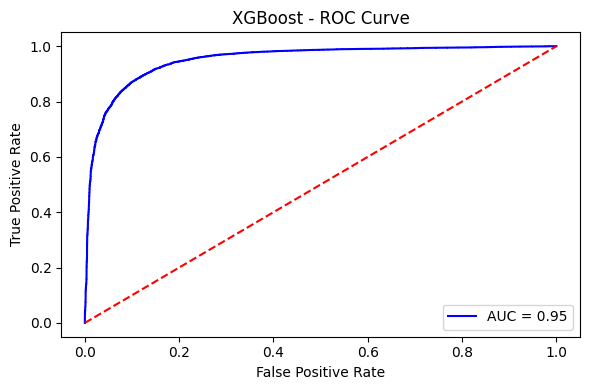

------------------------------------------------------------


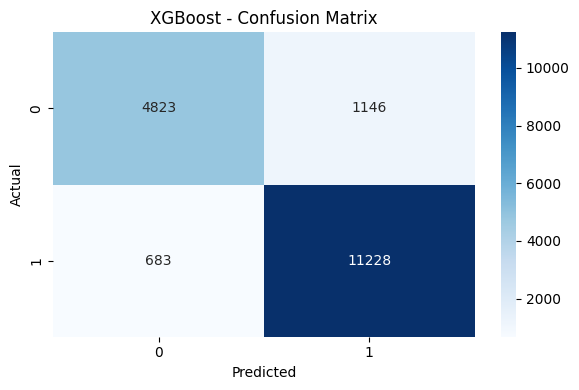

------------------------------------------------------------


In [58]:
make_roc_curve(xg_best_model, X_test, y_test, model_name="XGBoost")
print("-" * 60)
make_confusion_matrix(xg_best_model, X_test, y_test, model_name="XGBoost")
print("-" * 60)

### **2. Naive Bayes**

In [59]:
bayes_best_model, bayes_best_params, bayes_best_score, bayes_acc = grid_search_with_tqdm(
    "NaiveBayes",
    models["NaiveBayes"][0],
    models["NaiveBayes"][1],
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor,
)


🔹 Training NaiveBayes with Grid Search + SMOTE...
📊 Total parameter combinations: 3


Training NaiveBayes:   0%|          | 0/3 [00:00<?, ?comb/s]


✅ Finished training NaiveBayes.
🔍 Best F1-score: 0.880
✨ Best Parameters: {'classifier__var_smoothing': 1e-09}

📊 Final Evaluation for NaiveBayes
Accuracy: 0.880 | F1-score: 0.880

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      5969
           1       0.90      0.92      0.91     11911

    accuracy                           0.88     17880
   macro avg       0.87      0.86      0.86     17880
weighted avg       0.88      0.88      0.88     17880



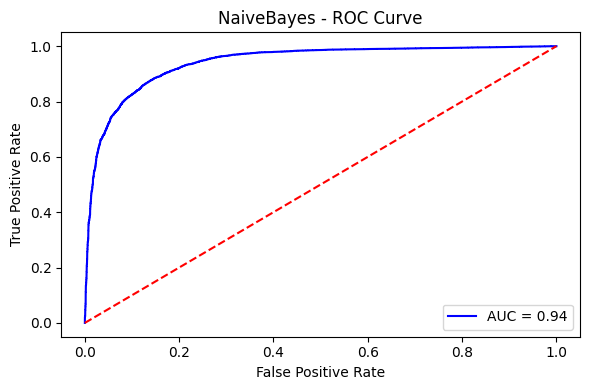

------------------------------------------------------------


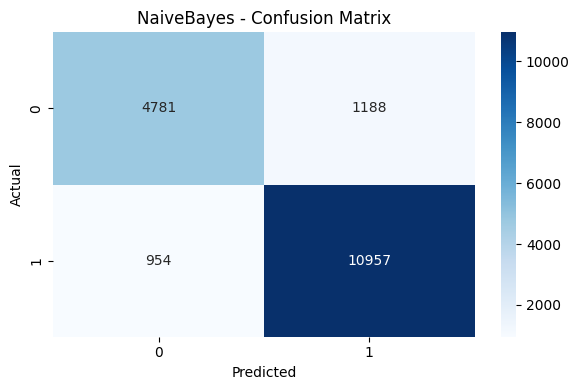

------------------------------------------------------------


In [60]:
make_roc_curve(bayes_best_model, X_test, y_test, model_name="NaiveBayes")
print("-" * 60)
make_confusion_matrix(bayes_best_model, X_test, y_test, model_name="NaiveBayes")
print("-" * 60)

### **3. Logistic Regression**

In [61]:
lr_best_model, lr_best_params, lr_best_score, lr_acc = grid_search_with_tqdm(
    "LogisticRegression",
    models["LogisticRegression"][0],
    models["LogisticRegression"][1],
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor,
)


🔹 Training LogisticRegression with Grid Search + SMOTE...
📊 Total parameter combinations: 6


Training LogisticRegression:   0%|          | 0/6 [00:00<?, ?comb/s]


✅ Finished training LogisticRegression.
🔍 Best F1-score: 0.886
✨ Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}

📊 Final Evaluation for LogisticRegression
Accuracy: 0.888 | F1-score: 0.886

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      5969
           1       0.90      0.94      0.92     11911

    accuracy                           0.89     17880
   macro avg       0.88      0.86      0.87     17880
weighted avg       0.89      0.89      0.89     17880



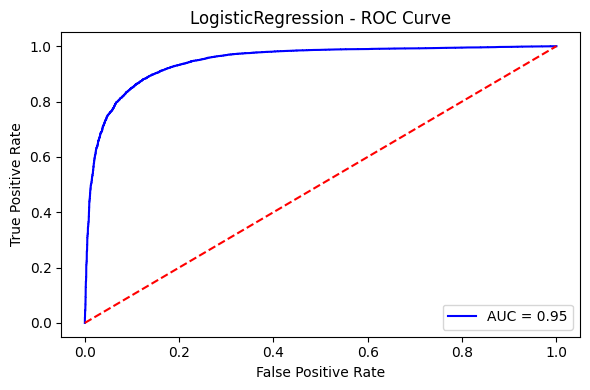

------------------------------------------------------------


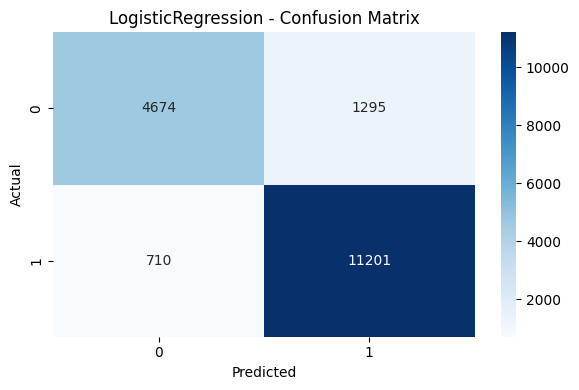

------------------------------------------------------------


In [62]:
make_roc_curve(lr_best_model, X_test, y_test, model_name="LogisticRegression")
print("-" * 60)
make_confusion_matrix(lr_best_model, X_test, y_test, model_name="LogisticRegression")
print("-" * 60)

### **4. K-Nearest Neighbors**

In [63]:
knn_best_model, knn_best_params, knn_best_score, knn_acc = grid_search_with_tqdm(
    "KNN",
    models["KNN"][0],
    models["KNN"][1],
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor,
)


🔹 Training KNN with Grid Search + SMOTE...
📊 Total parameter combinations: 6


Training KNN:   0%|          | 0/6 [00:00<?, ?comb/s]


✅ Finished training KNN.
🔍 Best F1-score: 0.875
✨ Best Parameters: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}

📊 Final Evaluation for KNN
Accuracy: 0.877 | F1-score: 0.875

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      5969
           1       0.89      0.93      0.91     11911

    accuracy                           0.88     17880
   macro avg       0.87      0.85      0.86     17880
weighted avg       0.88      0.88      0.87     17880



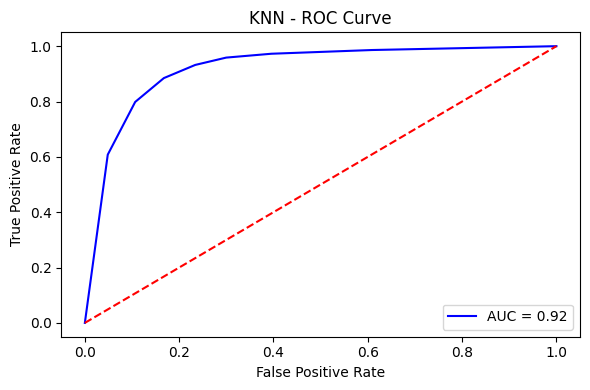

------------------------------------------------------------


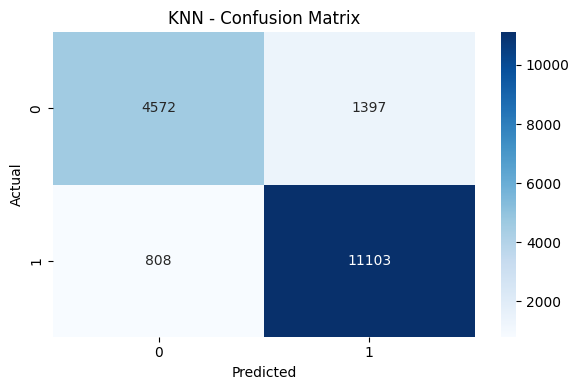

------------------------------------------------------------


In [64]:
make_roc_curve(knn_best_model, X_test, y_test, model_name="KNN")
print("-" * 60)
make_confusion_matrix(knn_best_model, X_test, y_test, model_name="KNN")
print("-" * 60)

### **5. Random Forest**

In [65]:
rf_best_model, rf_best_params, rf_best_score, rf_acc = grid_search_with_tqdm(
    "RandomForest",
    models["RandomForest"][0],
    models["RandomForest"][1],
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor,
)


🔹 Training RandomForest with Grid Search + SMOTE...
📊 Total parameter combinations: 24


Training RandomForest:   0%|          | 0/24 [00:00<?, ?comb/s]


✅ Finished training RandomForest.
🔍 Best F1-score: 0.891
✨ Best Parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

📊 Final Evaluation for RandomForest
Accuracy: 0.893 | F1-score: 0.891

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      5969
           1       0.90      0.94      0.92     11911

    accuracy                           0.89     17880
   macro avg       0.89      0.87      0.88     17880
weighted avg       0.89      0.89      0.89     17880



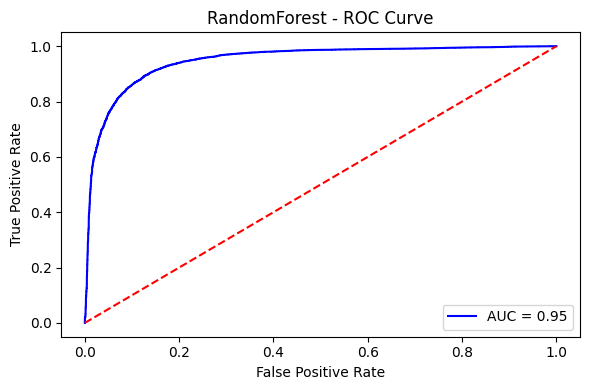

------------------------------------------------------------


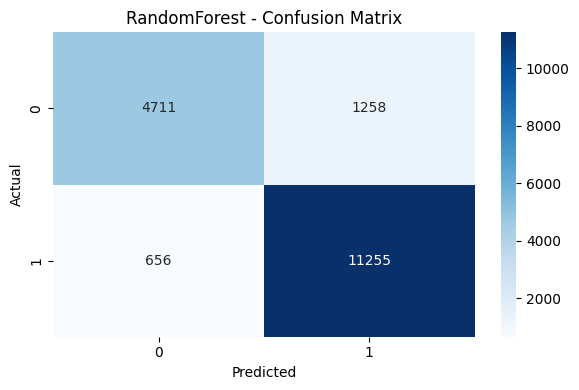

------------------------------------------------------------


In [66]:
make_roc_curve(rf_best_model, X_test, y_test, model_name="RandomForest")
print("-" * 60)
make_confusion_matrix(rf_best_model, X_test, y_test, model_name="RandomForest")
print("-" * 60)

## Comparing the Models by the Accuracy and F1-Score

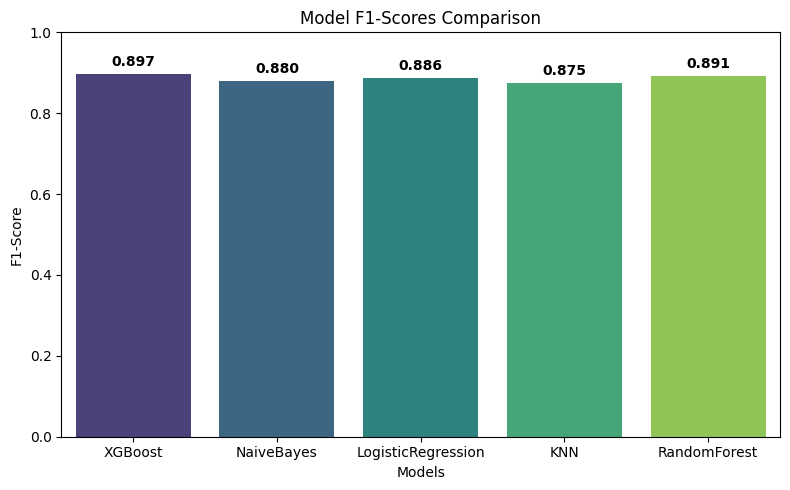

In [67]:
scores = {
    "XGBoost": xg_best_score,
    "NaiveBayes": bayes_best_score,
    "LogisticRegression": lr_best_score,
    "KNN": knn_best_score,
    "RandomForest": rf_best_score,
}
model_names = list(scores.keys())
f1_scores = list(scores.values())

# plot the scores
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f1_scores, palette="viridis", hue=model_names, dodge=False, legend=False)
plt.title("Model F1-Scores Comparison")
plt.ylabel("F1-Score")
plt.xlabel("Models")
plt.ylim(0, 1)
for i, v in enumerate(scores.values()): 
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

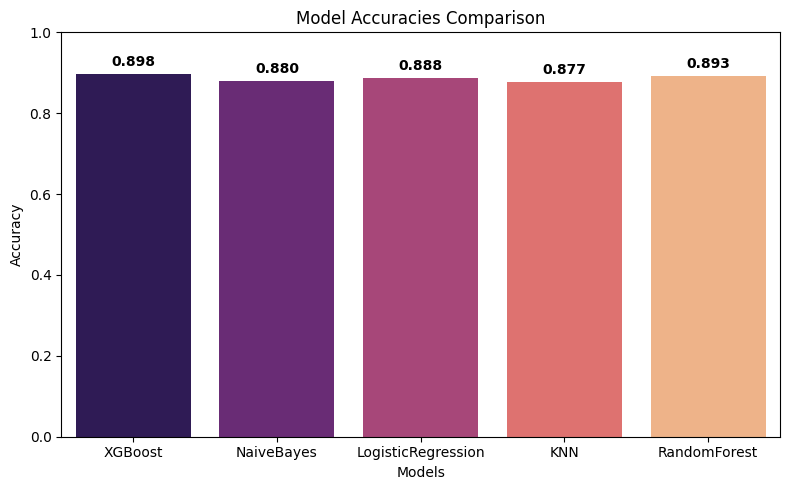

In [68]:
accuracies = {
    "XGBoost": xg_acc,
    "NaiveBayes": bayes_acc,
    "LogisticRegression": lr_acc,   
    "KNN": knn_acc,
    "RandomForest": rf_acc,
}

acc_values = list(accuracies.values())
model_names = list(accuracies.keys())

# plot the accuracies
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=acc_values, palette="magma", hue=model_names, dodge=False, legend=False)
plt.title("Model Accuracies Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()): 
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## Starting to Work with MLflow for Model Tracking and Deployment

In [69]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [70]:
best_models = {
    "Xgboost": {"pipeline": xg_best_model, "params": xg_best_params, "f1_score": xg_best_score, "accuracy": xg_acc},
    "NaiveBayes": {"pipeline": bayes_best_model, "params": bayes_best_params, "f1_score": bayes_best_score, "accuracy": bayes_acc},
    "LogisticRegression": {"pipeline": lr_best_model, "params": lr_best_params, "f1_score": lr_best_score, "accuracy": lr_acc},
    "KNN": {"pipeline": knn_best_model, "params": knn_best_params, "f1_score": knn_best_score, "accuracy": knn_acc},
    "RandomForest": {"pipeline": rf_best_model, "params": rf_best_params, "f1_score": rf_best_score, "accuracy": rf_acc}
} 

In [121]:
mlflow.set_experiment("classification_models")
mlflow.set_tracking_uri(uri="http://localhost:5000/")
for model_name, model_info in best_models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model_info["params"])
        mlflow.log_metric("f1_score", model_info["f1_score"])
        mlflow.log_metric("accuracy", model_info["accuracy"])
        X_sample = X_train.sample(5)
        
        mlflow.sklearn.log_model(
            model_info["pipeline"],
            name="model",
            signature=mlflow.models.infer_signature(
                X_sample, model_info["pipeline"].predict(X_sample)
            ),
        )
        print(
            f"Logged {model_name} to MLflow with F1-score: {model_info['f1_score']:.3f} and Accuracy: {model_info['accuracy']:.3f}."
        )

2025/11/17 20:21:07 INFO mlflow.tracking.fluent: Experiment with name 'classification_models' does not exist. Creating a new experiment.
/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged Xgboost to MLflow with F1-score: 0.897 and Accuracy: 0.898.
🏃 View run Xgboost at: http://localhost:5000/#/experiments/687432345526642784/runs/ba4808c85c6a440eb9627799b5708c98
🧪 View experiment at: http://localhost:5000/#/experiments/687432345526642784


/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged NaiveBayes to MLflow with F1-score: 0.880 and Accuracy: 0.880.
🏃 View run NaiveBayes at: http://localhost:5000/#/experiments/687432345526642784/runs/b919d26d71044c1c967e1c34ffdf878d
🧪 View experiment at: http://localhost:5000/#/experiments/687432345526642784


/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged LogisticRegression to MLflow with F1-score: 0.886 and Accuracy: 0.888.
🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/687432345526642784/runs/557467208e2d492bace04560c6dfb4f2
🧪 View experiment at: http://localhost:5000/#/experiments/687432345526642784


/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged KNN to MLflow with F1-score: 0.875 and Accuracy: 0.877.
🏃 View run KNN at: http://localhost:5000/#/experiments/687432345526642784/runs/43343846a6e4497bbb756170dd927952
🧪 View experiment at: http://localhost:5000/#/experiments/687432345526642784


/home/muhammed_mahmoud/Projects/python_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Logged RandomForest to MLflow with F1-score: 0.891 and Accuracy: 0.893.
🏃 View run RandomForest at: http://localhost:5000/#/experiments/687432345526642784/runs/84a089a9912d47ae85c27419246c3873
🧪 View experiment at: http://localhost:5000/#/experiments/687432345526642784


In [136]:
run_id = "ba4808c85c6a440eb9627799b5708c98"
loaded_rf = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")
preds = loaded_rf.predict(X_test)
accuracy_score(y_test, preds)

0.8980984340044743

In [137]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("classification_models")

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1_score DESC"],
    max_results=1
)

best_run = runs[0]
print("Best run:", best_run.info.run_id, best_run.data.metrics)

Best run: ba4808c85c6a440eb9627799b5708c98 {'f1_score': 0.897103081317998, 'accuracy': 0.8980984340044743}


In [150]:
model_uri = f"runs:/{best_run.info.run_id}/model"

result = mlflow.register_model(
    model_uri=model_uri,
    name="Classification_XGBoost_Prod"
)

print("Registered model:", result.name)
print("Version:", result.version)

Registered model 'Classification_XGBoost_Prod' already exists. Creating a new version of this model...
2025/11/17 20:57:28 WARNING mlflow.tracking._model_registry.fluent: Run with id ba4808c85c6a440eb9627799b5708c98 has no artifacts at artifact path 'model', registering model based on models:/m-eba496ea693b43e2a59481f61b86a54a instead
2025/11/17 20:57:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Classification_XGBoost_Prod, version 2
Created version '2' of model 'Classification_XGBoost_Prod'.


Registered model: Classification_XGBoost_Prod
Version: 2


In [151]:
model = mlflow.pyfunc.load_model(model_uri="models:/Classification_XGBoost_Prod/Production")

prediction = model.predict(X_test)
print(prediction)

[1 0 1 ... 0 0 1]


In [156]:
!mlflow models serve \
    -m "models:/Classification_XGBoost_Prod/Production" \
    -p 8000 \
    --no-conda

2025/11/17 21:03:53 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/11/17 21:03:55 INFO mlflow.pyfunc.backend: === Running command 'exec uvicorn --host 127.0.0.1 --port 8000 --workers 1 mlflow.pyfunc.scoring_server.app:app'
^C

Aborted!


In [159]:
!curl -X POST http://127.0.0.1:8000/invocations \
    -H "Content-Type: application/json" \
    -d '{"dataframe_split": {"columns": [...], "data": [...]}}'

{"error_code": "BAD_REQUEST", "message": "Invalid input. Ensure that input is a valid JSON formatted string. Error: 'JSONDecodeError('Expecting value: line 1 column 34 (char 33)')'\nInput: \nb'{\"dataframe_split\": {\"columns\": [...], \"data\": [...]}}'\n"}

In [163]:
!curl -X POST "http://127.0.0.1:8000/predict" \
-H "Content-Type: application/json" \
-d '{"Age": 35, "MonthlyIncome": 5000, "JobSatisfaction": 3}'


Internal Server Error